In [23]:
from anomaly import io, tmm, adm
from sklearn.metrics import f1_score
import scipy
import pandas as pd
import numpy as np

import anomaly.utils.modelselect_utils as mu
import anomaly.utils.statsutils as su
import matplotlib.pyplot as plt
import seaborn as sns

## The pipeline 

We demonstrate below how the anomaly detection pipeline is used

In [7]:
predictor = tmm.ARMA()
detector = adm.KSigma()

bench = io.BenchmarkDataset(2)
df = bench.read(8)
df.head()

,timestamp,value,is_anomaly
0,1416726000,409.526881,0
1,1416729600,-59.320025,0
2,1416733200,513.522583,0
3,1416736800,536.310600,0
4,1416740400,302.085952,0


In [8]:
ts = df.value

predictor.fit(np.array(ts))
ts_predicted = predictor.predict()
residuals = ts_predicted - ts

detector.fit(ts, ts_predicted)
is_anomaly = detector.detect()

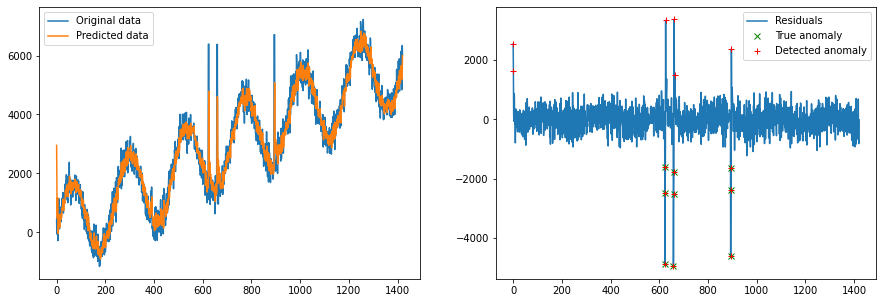

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plt.sca(axs[0])
plt.plot(ts, label="Original data")
plt.plot(ts_predicted, label="Predicted data")
plt.legend()

plt.sca(axs[1])
plt.plot(residuals, label="Residuals")
plt.plot(residuals[df.is_anomaly == 1], linestyle="", marker="x", color="green", label="True anomaly")
plt.plot(residuals[is_anomaly], linestyle="", marker="+", color="red", label="Detected anomaly")
plt.legend()

plt.show()

Here we can observe a failure of the method. ARMA fits the data too closely, and almost becomes a naive predictor which predicts $\hat{s}_t = s_{t-1}$. As a consequence, each down peak in the residual is followed by an up peak because the predictor has lagged the outlier. Of course, this can be fixed by choosing a predictors which handles well trend and seasonality.

### Do the residuals follow a gaussian distribution ?

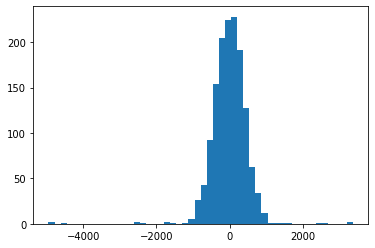

In [10]:
plt.hist(residuals, bins=50)
plt.show()

Here, the gaussian assumption seems ok from far away. However, this is not always the case, and more importantly, it is not gaussian in the statistical sense.

In [25]:
_, pvalue = scipy.stats.normaltest(residuals)
print(pvalue)

3.7140666983958233e-155


## Experiments

In [15]:
predictor_dict = {
    "naive_predictor" : tmm.NaivePredictor(),
    "ar5_predictor" : tmm.AR(order=5),
    "ma5_predictor" : tmm.MA(order=5),
    "arma55_predictor" : tmm.ARMA(order_ar=5, order_ma=5),
    "arima525_predictor" : tmm.ARIMA.ARIMA(order=[5,2,5]),
    "poly5_predictor" : tmm.Polynomial(degree=5),
    "trigonometric": tmm.Trigonometric(),
    "poly+arma": tmm.Sequential(predictors=[tmm.Polynomial(), tmm.ARMA()]),
    "poly+trigo":tmm.Sequential(predictors=[tmm.Polynomial(), tmm.Trigonometric()]),
    "poly+trigo+arma": tmm.Sequential(predictors=[tmm.Polynomial(), tmm.Trigonometric(), tmm.ARMA()]),
}

### Compute the features and the scores of the models for each time series in the benchmark

⚠️ Don't run those cells, the results are already saved ! ⚠️

Compute features:

In [ ]:
%%capture --no-stdout

for benchmark_index in range(1,5):
    bench = io.BenchmarkDataset(benchmark_index)
    
    features = mu.compute_benchmark_features(bench)
    features.to_csv(f"saved_data/features_{benchmark_index}.csv", index_label="ts_index")

Compute scores:

In [17]:
%%capture --no-stdout

for benchmark_index in range(1,3):
    bench = io.BenchmarkDataset(benchmark_index)

    score_dict = mu.compute_predictor_scores(predictor_dict, bench, detector=adm.KSigma())
    score_df = pd.concat([score_dict[model_name].assign(model_name=model_name)
                      for model_name in score_dict.keys()])
    
    score_df.to_csv(f"saved_data/score_df_{benchmark_index}.csv", index_label="ts_index")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [25:40<00:00, 15.40s/it]


### Analyse the results

#### Read the saved data

In [8]:
benchmark_index = 1

In [9]:
score_df = pd.read_csv(f"saved_data/score_df_{benchmark_index}.csv").set_index("ts_index")
features = pd.read_csv(f"saved_data/features_{benchmark_index}.csv").set_index("ts_index")

In [10]:
features_normalized = (features - features.mean()) / features.std()
features_normalized

,periodicity,trend_score,seasonality_score,nonlinearity,skew,kurtosis,hurst,lyapunov
ts_index,,,,,,,,
0,-0.482247,0.345419,0.368635,-0.183999,-0.805597,-0.418547,-2.448017,-0.943255
1,-0.605100,0.917413,0.404204,-0.179964,-0.093253,-0.302400,-0.010275,-0.426603
2,-0.543674,0.404657,0.293232,-0.184960,-0.484402,-0.420599,-1.111591,-0.804940
3,2.773377,-0.602988,0.324246,0.410316,0.148304,-0.291704,1.054703,-0.305958
4,0.162735,-0.093066,0.319707,0.125309,0.466526,-0.120375,0.068809,-0.033801
...,...,...,...,...,...,...,...,...
62,-0.436177,0.495551,-1.766353,-0.178423,-0.437167,-0.412511,1.419668,-0.047123
63,-0.605100,0.917413,0.404204,-0.183719,-0.643199,-0.428834,-0.738089,-0.491377
64,-0.451533,0.357432,0.346942,-0.181374,0.657620,0.183085,1.210540,-0.574990


In [11]:
score_df

,bias,mad,mape,mse,sae,f1,recall,model_name
ts_index,,,,,,,,
0,-0.000286,0.211534,5.327644e+04,0.107670,301.012335,0.000000,0.000000,naive_predictor
1,-1.750000,279.599719,2.709001e-01,291579.873596,398150.000000,0.242424,0.235294,naive_predictor
2,-0.000694,6.655795,7.147887e+04,75.717557,9591.000000,0.000000,0.000000,naive_predictor
3,-0.462718,5.181882,7.038333e+05,290.448780,7436.000000,0.612903,0.441860,naive_predictor
4,-0.146067,28.721910,3.535816e+06,15624.842697,40900.000000,0.560000,0.666667,naive_predictor
...,...,...,...,...,...,...,...,...
62,-0.000063,0.020254,1.000000e+00,0.002081,29.166131,0.291667,0.218750,poly+trigo+arma
63,0.402274,87.418727,1.000000e+00,38840.407229,124746.522906,0.375000,0.600000,poly+trigo+arma
64,0.554787,45.447618,1.000000e+00,8430.929374,65217.332003,0.285714,1.000000,poly+trigo+arma


In [18]:
def get_features(benchmark_index):
    features = pd.read_csv(f"saved_data/features_{benchmark_index}.csv").set_index("ts_index")
    features_normalized = (features - features.mean()) / features.std()
    return features_normalized.to_numpy()

def get_best_model(benchmark_index):
    score_df = pd.read_csv(f"saved_data/score_df_{benchmark_index}.csv").set_index("ts_index")
    pivot_init = score_df[["f1", "model_name"]]
    df = pd.pivot_table(pivot_init, index="ts_index", columns="model_name", values="f1")
    df_np = df.to_numpy()
    return df_np.argmax(axis=1)

#### Plot the results depending on the features using PCA

In [19]:
from sklearn import decomposition

features_np = get_features(benchmark_index=1)
best_model = get_best_model(benchmark_index=1)

pca = decomposition.PCA(n_components=2)
XY = pca.fit_transform(features_np)

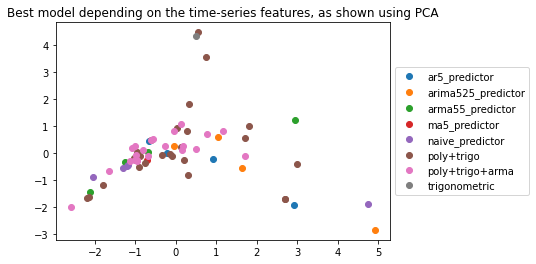

In [20]:
plot_df = pd.DataFrame(XY, columns=["X", "Y"])
plot_df["category"] = np.array(list(predictor_dict.keys()))[best_model]

groups = plot_df.groupby("category")
for name, group in groups:
    plt.plot(group["X"], group["Y"], marker="o", linestyle="", label=name)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Best model depending on the time-series features, as shown using PCA")

plt.savefig("figs/best_model_PCA.png",  bbox_inches = 'tight')

### See how each feature affects the fscore using a linear regression

In [23]:
import statsmodels.formula.api as smf

for predictor_name in ["poly5_predictor", "ma5_predictor"]:
    print(f"------------------------- {predictor_name} --------------------------------")
    score_model_df = score_df[score_df["model_name"] == predictor_name].reset_index(drop=True)
    
    df = features_normalized.join(score_model_df,  on="ts_index")
    
    smresults = smf.ols('f1 ~ trend_score + seasonality_score + nonlinearity + skew + kurtosis + hurst + lyapunov', df).fit()
    smresults_robust = smresults.get_robustcov_results()
    print(smresults_robust.summary())

------------------------- poly5_predictor --------------------------------
                            OLS Regression Results                            
Dep. Variable:                     f1   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     20.60
Date:                Wed, 30 Mar 2022   Prob (F-statistic):           1.03e-13
Time:                        19:39:00   Log-Likelihood:                -8.8122
No. Observations:                  67   AIC:                             33.62
Df Residuals:                      59   BIC:                             51.26
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

### Compare fscores of the pipeline

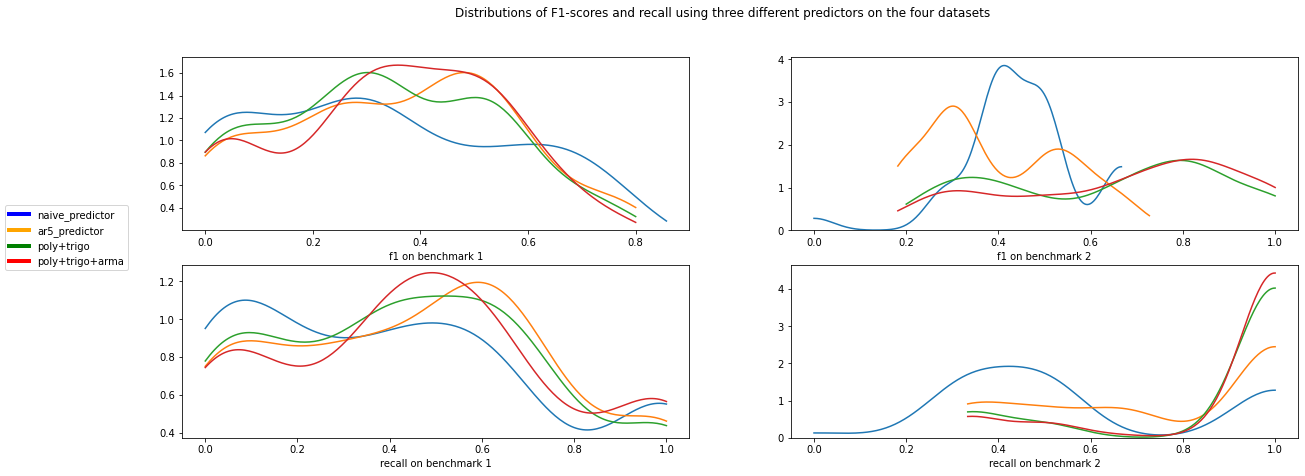

In [22]:
keep = [
    "naive_predictor",
    "ar5_predictor",
    "poly+trigo",
    "poly+trigo+arma",
]

fig, axes = plt.subplots(2,2, sharex=False, sharey=False, figsize=(20,7))
fig.suptitle('Distributions of F1-scores and recall using three different predictors on the four datasets')

scores = ["f1", "recall"]
benchmarks = [f"benchmark_{i}" for i in range(1,3)]


for j in range(len(benchmarks)):
    benchmark_index = j + 1
    score_df = pd.read_csv(f"saved_data/score_df_{benchmark_index}.csv").set_index("ts_index")
    
    for i in range(len(scores)):
        for model_name in keep:
            score_df_to_plot = score_df[score_df.model_name == model_name].reset_index()
            sns.kdeplot(data=score_df_to_plot, x=scores[i],
                   bw_adjust=.8, cut=0, ax=axes[i,j])
            
        axes[i,j].set_ylabel("")
        axes[i,j].set_xlabel(f"{scores[i]} on benchmark {benchmark_index}")
            
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="blue", lw=4),
                Line2D([0], [0], color="orange", lw=4),
                Line2D([0], [0], color="green", lw=4),
                Line2D([0], [0], color="red", lw=4)]



fig.legend(custom_lines, keep, loc="center left")
plt.savefig("figs/F1_recall.png",  bbox_inches = 'tight')